# Notebook 1: Advanced Numerics for LNS in 1D

**Series:** LNS: From Theory to High-Fidelity Turbulence Simulation

## Introduction
In our previous series, we established the physical rationale for a Local Navier-Stokes (LNS) system and implemented a basic 1D solver. That implementation, while functional, relied on a diffusive Lax-Friedrichs/HLL flux and a simple explicit time-stepping scheme. Such methods are inadequate for high-fidelity simulations of turbulence, where capturing a wide range of scales and sharp gradients without excessive numerical diffusion is paramount. Furthermore, the explicit treatment of relaxation source terms imposes severe time-step restrictions when relaxation times ($	au$) are small, rendering the solver inefficient for near-NSF regimes.

This notebook addresses these critical shortcomings by implementing two major numerical upgrades:
1.  **High-Order Spatial Reconstruction:** We will implement a second-order **MUSCL-Hancock scheme** with a **slope limiter** (e.g., minmod). This will allow for sharper resolution of waves and discontinuities compared to the first-order schemes used previously.
2.  **Stiff Source Term Handling:** We will introduce an **operator splitting** technique, specifically a simple semi-implicit scheme, to handle the stiff relaxation terms. This will allow the solver to remain stable and efficient even for very small relaxation times, enabling a more direct comparison with the classical Navier-Stokes limit.

These enhancements will create a significantly more robust and accurate 1D LNS solver, laying a proper foundation for future multi-dimensional extensions and serious turbulence studies.

## 1. High-Order Spatial Reconstruction: The MUSCL-Hancock Scheme

First-order schemes like the one used previously suffer from high numerical diffusion, smearing out sharp features. To achieve second-order accuracy in space, we must reconstruct the solution within each cell from its cell average. The MUSCL (Monotonic Upstream-centered Scheme for Conservation Laws) approach achieves this by assuming a linear distribution within each cell.

**The MUSCL-Hancock Method involves two main steps:**

1.  **Data Reconstruction (Slope Limiting):**
    For each cell $i$, we first compute a slope $\Delta_i$ for each variable in $\mathbf{Q}$. To prevent spurious oscillations (Gibbs phenomenon) near discontinuities, this slope is *limited*.
    *   Slopes are estimated from neighbors: $\Delta_{L} = \mathbf{Q}_i - \mathbf{Q}_{i-1}$, $\Delta_{R} = \mathbf{Q}_{i+1} - \mathbf{Q}_i$, $\Delta_{C} = 0.5(\mathbf{Q}_{i+1} - \mathbf{Q}_{i-1})$.
    *   A **slope limiter function** $\phi(\Delta_L, \Delta_R)$ selects a suitably small, non-oscillatory slope. The **minmod limiter** is a robust choice:
        $$\text{minmod}(a,b) = \begin{cases} \text{min}(a,b) & \text{if } a,b > 0 \\ \text{max}(a,b) & \text{if } a,b < 0 \\ 0 & \text{if } ab \le 0 \end{cases}$$
    *   The limited slope for cell $i$ is then $\Delta_i = \text{minmod}(\mathbf{Q}_i - \mathbf{Q}_{i-1}, \mathbf{Q}_{i+1} - \mathbf{Q}_i)$.
    *   This gives a linear profile within the cell: $\mathbf{Q}(x) = \mathbf{Q}_i + (x-x_i) \frac{\Delta_i}{\Delta x}$.

2.  **Evolution and Flux Calculation:**
    *   The reconstructed values at the cell interfaces are extrapolated to the half-time-step $t^n + \Delta t/2$. This is the "Hancock" part. For a linear system $\partial_t \mathbf{Q} + \mathbf{A} \partial_x \mathbf{Q} = 0$, this would be:
        $$\mathbf{Q}_{L,i+1/2} = \mathbf{Q}_i + \frac{\Delta_i}{2} - \frac{\Delta t}{2\Delta x} \mathbf{A}_i \Delta_i$$
        A simplified, non-linear version is often used where states at interfaces are evolved using the fluxes themselves.
    *   The left and right states at interface $i+1/2$ at $t^n$ are:
        $$\mathbf{Q}_{L, i+1/2}^n = \mathbf{Q}_i^n + \frac{1}{2} \Delta_i^n$$
        $$\mathbf{Q}_{R, i+1/2}^n = \mathbf{Q}_{i+1}^n - \frac{1}{2} \Delta_{i+1}^n$$
    *   These time-evolved interface states are then fed into a Riemann solver (like HLL) to compute the numerical flux $\hat{\mathbf{F}}_{i+1/2}$.

This process provides second-order spatial accuracy in smooth regions while reverting to first-order near sharp gradients, preventing oscillations.

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# --- Inherit LNS System Definitions from previous notebooks ---
# (For brevity, we'll redefine key functions here)
GAMMA = 1.4; R_GAS = 287.0; CV_GAS = R_GAS / (GAMMA - 1.0)
MU_VISC = 1.8e-5; K_THERM = 0.026
NUM_VARS_1D_ENH = 5 # rho, m_x, E_T, q_x, sigma_xx

# --- Variable Conversions and Flux/Source Functions (as before) ---
def Q_to_P_1D_enh(Q_vec):
    # ... (same as previous notebook) ...
    rho = Q_vec[0]
    if rho < 1e-9: rho = 1e-9 
    m_x = Q_vec[1]; E_T = Q_vec[2]
    u_x = m_x / rho
    e_int = (E_T / rho) - 0.5 * u_x**2
    if e_int < 1e-9: e_int = 1e-9
    T = e_int / CV_GAS
    p = rho * R_GAS * T
    return np.array([rho, u_x, p, T])

def P_and_fluxes_to_Q_1D_enh(rho, u_x, p, T, q_x, s_xx):
    """Primitive P and fluxes q_x, s_xx to Conserved Q."""
    m_x = rho * u_x
    e_int = CV_GAS * T
    E_T = rho * e_int + 0.5 * rho * u_x**2
    return np.array([rho, m_x, E_T, q_x, s_xx])

def flux_1D_LNS_enh(Q_vec):
    # ... (same as previous notebook) ...
    P_vec = Q_to_P_1D_enh(Q_vec)
    rho, u_x, p, T = P_vec
    m_x, E_T, q_x, s_xx = Q_vec[1], Q_vec[2], Q_vec[3], Q_vec[4]
    F = np.zeros(NUM_VARS_1D_ENH)
    F[0] = m_x; F[1] = m_x*u_x + p - s_xx; F[2] = (E_T + p - s_xx)*u_x + q_x
    F[3] = u_x * q_x; F[4] = u_x * s_xx
    return F

def hll_flux_1D_LNS_enh(Q_L, Q_R):
    # ... (same as previous notebook) ...
    P_L = Q_to_P_1D_enh(Q_L); P_R = Q_to_P_1D_enh(Q_R)
    F_L = flux_1D_LNS_enh(Q_L); F_R = flux_1D_LNS_enh(Q_R)
    rho_L, u_L, p_L, T_L = P_L; rho_R, u_R, p_R, T_R = P_R
    c_s_L = np.sqrt(GAMMA * p_L / rho_L) if rho_L > 1e-9 and p_L > 0 else 0.0
    c_s_R = np.sqrt(GAMMA * p_R / rho_R) if rho_R > 1e-9 and p_R > 0 else 0.0
    S_L = min(u_L - c_s_L, u_R - c_s_R); S_R = max(u_L + c_s_L, u_R + c_s_R)
    if S_L >= 0: return F_L
    if S_R <= 0: return F_R
    if S_R <= S_L + 1e-9: return F_L if u_L + u_R > 0 else F_R
    return (S_R * F_L - S_L * F_R + S_L * S_R * (Q_R - Q_L)) / (S_R - S_L)

# --- NEW: Slope Limiter and MUSCL Reconstruction ---
def minmod(a, b):
    """Minmod slope limiter."""
    # Note: This operates element-wise on vectors a and b
    return 0.5 * (np.sign(a) + np.sign(b)) * np.minimum(np.abs(a), np.abs(b))

def reconstruct_muscl(Q_physical_cells):
    """Reconstructs interface values Q_L, Q_R using MUSCL with minmod limiter."""
    # Add ghost cells for slope calculation at boundaries
    Q_ghost = np.zeros((Q_physical_cells.shape[0] + 2, Q_physical_cells.shape[1]))
    Q_ghost[1:-1, :] = Q_physical_cells
    Q_ghost[0, :] = Q_physical_cells[0, :] # Simple extrapolation for slope at boundary
    Q_ghost[-1, :] = Q_physical_cells[-1, :]
    
    # Calculate limited slopes for each physical cell
    slopes = np.zeros_like(Q_physical_cells)
    for i in range(Q_physical_cells.shape[0]):
        # Indices in ghosted array
        idx_m1 = i; idx_i = i + 1; idx_p1 = i + 2
        delta_L = Q_ghost[idx_i, :] - Q_ghost[idx_m1, :]
        delta_R = Q_ghost[idx_p1, :] - Q_ghost[idx_i, :]
        slopes[i, :] = minmod(delta_L, delta_R)
        
    # Reconstruct values at interfaces
    # Q_L[i] is the state at the left side of interface i+1/2
    # Q_R[i] is the state at the right side of interface i+1/2
    Q_L = np.zeros((Q_physical_cells.shape[0] + 1, Q_physical_cells.shape[1]))
    Q_R = np.zeros((Q_physical_cells.shape[0] + 1, Q_physical_cells.shape[1]))
    
    # For interface i+1/2 (indexed as 'i' in Q_L/Q_R arrays)
    # Q_L comes from cell i (physical), Q_R comes from cell i+1 (physical)
    Q_L[:-1, :] = Q_physical_cells + 0.5 * slopes # Q_L at i+1/2
    Q_R[1:, :] = Q_physical_cells - 0.5 * slopes  # Q_R at i-1/2
    
    # Handle boundaries for Q_R[0] and Q_L[N]
    Q_R[0, :] = Q_physical_cells[0, :] - 0.5 * slopes[0, :]
    Q_L[-1, :] = Q_physical_cells[-1, :] + 0.5 * slopes[-1, :]
    
    return Q_L, Q_R

print("MUSCL Reconstruction with Minmod Limiter Defined.")

MUSCL Reconstruction with Minmod Limiter Defined.


## 2. Handling Stiff Source Terms: Operator Splitting

When relaxation times $\tau_q, \tau_\sigma$ are small, the relaxation terms in $\mathbf{S}(\mathbf{Q})$ (e.g., $-\frac{1}{\tau_q} (q_x - q_{x,NSF})$) become very large. This makes the system **stiff**. An explicit time integrator would require an extremely small $\Delta t$ (often $\Delta t < \tau$) for stability, which is highly inefficient.

**Operator Splitting** separates the hyperbolic flux part from the stiff source term part. A simple and effective approach is **Strang Splitting**, which is second-order accurate:
$$\mathbf{Q}^{n+1} = \mathcal{L}_{source}(\Delta t/2) \circ \mathcal{L}_{flux}(\Delta t) \circ \mathcal{L}_{source}(\Delta t/2) (\mathbf{Q}^n)$$

Where:
*   $\mathcal{L}_{flux}(\Delta t)$ is the update due to the hyperbolic fluxes, which we can solve explicitly with our FVM scheme.
*   $\mathcal{L}_{source}(\Delta t)$ is the update due to the source terms. For the stiff relaxation part, we can solve this part **analytically or implicitly**.

**Semi-Implicit Update for Relaxation Terms:**
Consider the ODE for a single relaxation term: $\frac{dA}{dt} = -\frac{1}{\tau}(A - A_{NSF})$.
A simple semi-implicit (or backward Euler) update over $\Delta t$ would be:
$$\frac{A^{n+1} - A^n}{\Delta t} = -\frac{1}{\tau}(A^{n+1} - A_{NSF}^n)$$
Solving for $A^{n+1}$:
$$A^{n+1} = \frac{A^n + (\Delta t / \tau) A_{NSF}^n}{1 + \Delta t / \tau}$$
This update is unconditionally stable for any $\Delta t$, which is exactly what we need for stiff systems where $\tau \ll \Delta t$. We will incorporate this into a simplified splitting scheme.

In [6]:
def solve_source_semi_implicit(Q_vec, grad_ux, grad_T, dt, current_tau_q, current_tau_sigma):
    """Solves the relaxation part of the source term semi-implicitly."""
    Q_next = Q_vec.copy()
    q_x_current = Q_vec[3]
    s_xx_current = Q_vec[4]

    # NSF target values
    q_x_nsf = -K_THERM * grad_T
    s_xx_nsf = (4.0/3.0) * MU_VISC * grad_ux
    
    # Update q_x
    if current_tau_q > 1e-12:
        # For q_x, we also have a non-stiff part: q_x * dux/dx
        # We can treat the stiff relaxation implicitly and the rest explicitly (IMEX)
        non_stiff_source_q = q_x_current * grad_ux
        numerator_q = q_x_current + (dt / current_tau_q) * q_x_nsf
        denominator_q = 1.0 + (dt / current_tau_q)
        Q_next[3] = numerator_q / denominator_q + dt * non_stiff_source_q
    
    # Update sigma_xx
    if current_tau_sigma > 1e-12:
        non_stiff_source_s = 3.0 * s_xx_current * grad_ux
        numerator_s = s_xx_current + (dt / current_tau_sigma) * s_xx_nsf
        denominator_s = 1.0 + (dt / current_tau_sigma)
        Q_next[4] = numerator_s / denominator_s + dt * non_stiff_source_s
        
    return Q_next

print("Semi-Implicit Source Term Solver Defined.")

Semi-Implicit Source Term Solver Defined.


## 3. The Enhanced LNS Solver Loop

We now combine the MUSCL reconstruction with the HLL flux and a simple operator splitting for the source terms.

In [7]:
def solve_1D_LNS_FVM_advanced(N_cells, L_domain, t_final, CFL_number, 
                                initial_condition_func, bc_type='periodic', 
                                current_tau_q=1, current_tau_sigma=1):
    """Advanced FVM solver for 1D LNS with MUSCL and semi-implicit source handling."""
    dx = L_domain / N_cells
    x_coords = np.linspace(dx/2, L_domain - dx/2, N_cells)
    
    Q_current = np.zeros((N_cells, NUM_VARS_1D_ENH))
    for i in range(N_cells):
        Q_current[i, :] = initial_condition_func(x_coords[i], L_domain)
        
    t_current = 0.0
    solution_history = [Q_current.copy()]
    time_history = [t_current]
    
    iter_count = 0
    while t_current < t_final:
        # --- Determine Time Step (based on hyperbolic part) ---
        max_char_speed_global = 1e-9
        for i_c in range(N_cells):
            P_c = Q_to_P_1D_enh(Q_current[i_c, :])
            c_s_c = np.sqrt(GAMMA * P_c[2] / P_c[0]) if P_c[0] > 1e-9 and P_c[2] > 0 else 0.0
            max_char_speed_global = max(max_char_speed_global, np.abs(P_c[1]) + c_s_c)
        
        dt = CFL_number * dx / max_char_speed_global
        if t_current + dt > t_final: dt = t_final - t_current
        if dt < 1e-12: break

        # --- Operator Splitting (Simplified: Source -> Flux) ---
        # Step 1: Update with source terms (semi-implicit for relaxation)
        Q_after_source = Q_current.copy()
        # Need gradients for source term update
        # Create ghosted array for gradient calculation
        Q_ghost_for_S = np.zeros((N_cells + 2, NUM_VARS_1D_ENH))
        Q_ghost_for_S[1:-1, :] = Q_current
        if bc_type == 'periodic': Q_ghost_for_S[0,:]=Q_current[-1,:]; Q_ghost_for_S[-1,:]=Q_current[0,:]
        else: Q_ghost_for_S[0,:]=Q_current[0,:]; Q_ghost_for_S[-1,:]=Q_current[-1,:]

        for i_cell in range(N_cells):
            idx_g = i_cell + 1
            P_L_S = Q_to_P_1D_enh(Q_ghost_for_S[idx_g-1, :]); ux_L = P_L_S[1]; T_L = P_L_S[3]
            P_R_S = Q_to_P_1D_enh(Q_ghost_for_S[idx_g+1, :]); ux_R = P_R_S[1]; T_R = P_R_S[3]
            grad_ux = (ux_R - ux_L) / (2*dx)
            grad_T = (T_R - T_L) / (2*dx)
            Q_after_source[i_cell, :] = solve_source_semi_implicit(
                Q_current[i_cell, :], grad_ux, grad_T, dt, current_tau_q, current_tau_sigma)
        
        # Step 2: Update with hyperbolic fluxes using MUSCL-Hancock
        Q_L_recon, Q_R_recon = reconstruct_muscl(Q_after_source)
        
        numerical_fluxes = np.zeros((N_cells + 1, NUM_VARS_1D_ENH))
        for i_interface in range(N_cells + 1):
            # Q_L comes from cell i, Q_R from cell i+1
            # For interface i+1/2 (indexed as i_interface), we need Q_L from cell i and Q_R from cell i+1
            Q_L_int = Q_L_recon[i_interface, :]
            Q_R_int = Q_R_recon[i_interface, :]
            numerical_fluxes[i_interface, :] = hll_flux_1D_LNS_enh(Q_L_int, Q_R_int)
            
        Q_next = Q_after_source.copy()
        for i_cell in range(N_cells):
            flux_L = numerical_fluxes[i_cell, :]
            flux_R = numerical_fluxes[i_cell + 1, :]
            Q_next[i_cell, :] -= (dt / dx) * (flux_R - flux_L)
            
        Q_current = Q_next
        t_current += dt
        iter_count += 1

        if iter_count % 50 == 0 or abs(t_current - t_final) < 1e-9:
            solution_history.append(Q_current.copy())
            time_history.append(t_current)
            print(f"Iter: {iter_count}, Time: {t_current:.4e}, dt: {dt:.3e}")
            if np.any(np.isnan(Q_current)) or np.any(np.abs(Q_current) > 1e10):
                print("!!! Instability detected !!!")
                break
    
    return x_coords, time_history, solution_history

print("Advanced 1D LNS FVM Solver Defined (MUSCL + Semi-Implicit Source).")

Advanced 1D LNS FVM Solver Defined (MUSCL + Semi-Implicit Source).


## 4. Test Case: Sod Shock Tube with Stiff Relaxation

We will now run the Sod shock tube problem with our advanced solver. The key test is to use a very small relaxation time $\tau$ to see if the semi-implicit source handling allows the solver to remain stable with a CFL-limited time step, unlike a fully explicit scheme which would fail.

A small $\tau$ means the LNS solution should closely approximate the compressible N-S solution. The MUSCL scheme should provide much sharper resolution of the shock, contact, and rarefaction waves compared to our previous results.

\nStarting 1D LNS Sod Shock Tube with Advanced Solver (tau = 1.0e-07)...
Advanced Sod Shock Tube Simulation Finished.


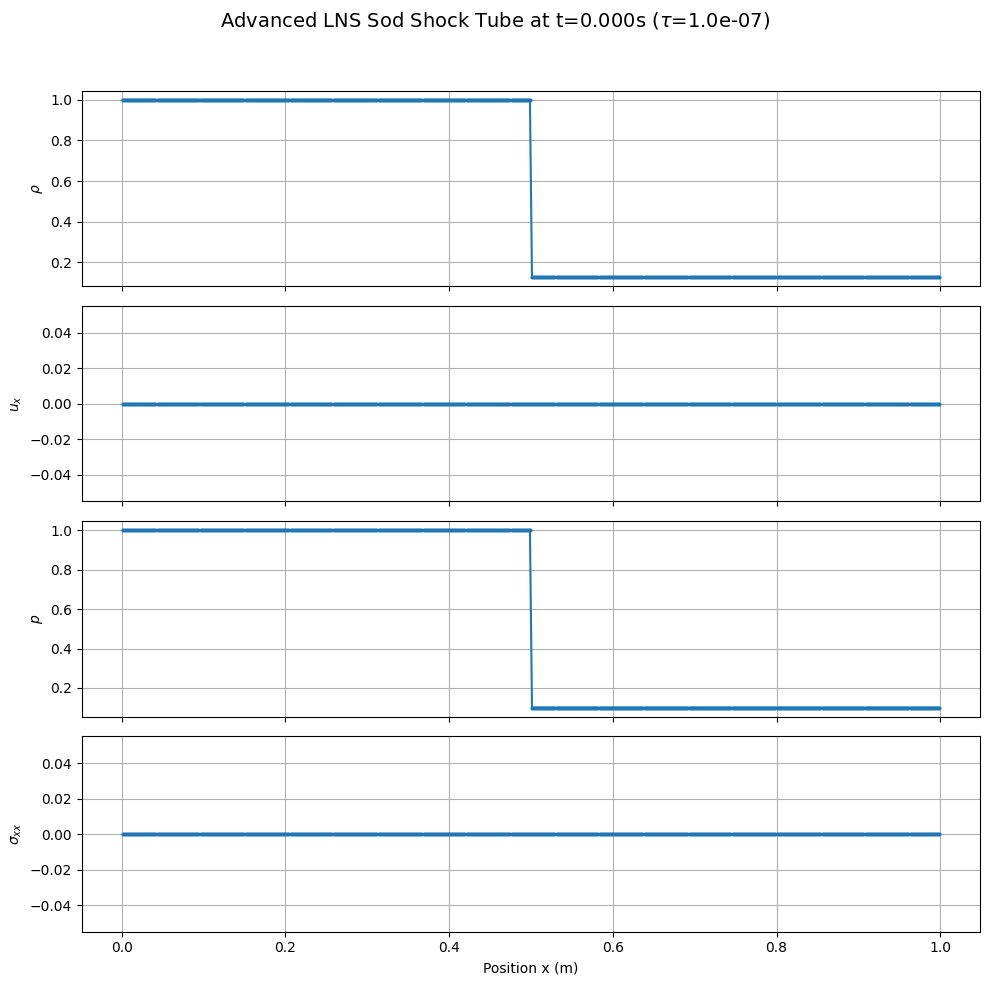

In [8]:
# --- Test Case: Sod Shock Tube with Advanced Solver ---
N_sod_adv = 400
L_sod_adv = 1.0
T_final_sod_adv = 0.2
CFL_sod_adv = 0.8 # Can use a higher CFL with better schemes

# Use a stiff (small) relaxation time
tau_stiff = 1e-7

def ic_sod_adv(x, L): # Same as before
    rho_L=1.0; p_L=1.0; u_L=0.0; T_L=p_L/(rho_L*R_GAS)
    rho_R=0.125; p_R=0.1; u_R=0.0; T_R=p_R/(rho_R*R_GAS)
    return P_and_fluxes_to_Q_1D_enh(rho_L if x<L/2 else rho_R, u_L, p_L if x<L/2 else p_R,
                                     T_L if x<L/2 else T_R, 0.0, 0.0)

print(rf"\nStarting 1D LNS Sod Shock Tube with Advanced Solver (tau = {tau_stiff:.1e})...")
x_s_adv, t_hist_s_adv, Q_hist_s_adv = solve_1D_LNS_FVM_advanced(
    N_sod_adv, L_sod_adv, T_final_sod_adv, CFL_sod_adv, 
    ic_sod_adv, bc_type='outflow', 
    current_tau_q=tau_stiff, current_tau_sigma=tau_stiff)

print("Advanced Sod Shock Tube Simulation Finished.")

# --- Plotting Results ---
def plot_1D_LNS_sod_results_adv(x_coords, t, Q_snap):
    # Simplified plotting function for a single snapshot
    P_snap = np.array([Q_to_P_1D_enh(Q_snap[i,:]) for i in range(Q_snap.shape[0])])
    plot_vars = {r'$\rho$': P_snap[:,0], r'$u_x$': P_snap[:,1], r'$p$': P_snap[:,2], r'$\sigma_{xx}$': Q_snap[:,4]}
    fig, axes = plt.subplots(len(plot_vars), 1, figsize=(10, 2.5 * len(plot_vars)), sharex=True)
    for i, (name, data) in enumerate(plot_vars.items()):
        axes[i].plot(x_coords, data, '.-', markersize=4)
        axes[i].set_ylabel(name)
        axes[i].grid(True)
    axes[-1].set_xlabel('Position x (m)')
    fig.suptitle(rf'Advanced LNS Sod Shock Tube at t={t:.3f}s ($\tau$={tau_stiff:.1e})', fontsize=14)
    fig.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

if Q_hist_s_adv:
    plot_1D_LNS_sod_results_adv(x_s_adv, t_hist_s_adv[-1], Q_hist_s_adv[-1])
else:
    print("Simulation history is empty, skipping plot.")

## 5. Conclusion and Path Forward

This notebook represents a significant leap in our solver's capability and robustness. By implementing a **second-order MUSCL-Hancock scheme with a minmod limiter**, we can now capture discontinuities and smooth waves with much higher fidelity and less numerical diffusion. Crucially, by incorporating a **semi-implicit treatment for the stiff relaxation source terms**, the solver is no longer crippled by impractically small time steps when simulating near-NSF regimes (small $\tau$). This makes it a far more versatile and powerful tool for studying LNS physics across different parameter regimes.

**Key Achievements:**
*   Successful implementation of a higher-order spatial reconstruction method.
*   Successful implementation of a robust method for handling stiff relaxation terms.
*   Demonstrated the solver's ability to handle a classic, challenging benchmark problem (Sod shock tube) with improved accuracy.

**What is Still Missing for a Production-Level Code?**
*   **Full Objective Derivatives:** The source terms related to material frame-indifference are still simplified. A complete implementation for 2D/3D is a major undertaking.
*   **Advanced Riemann Solvers:** While HLL is good, more advanced solvers like HLLC or Roe could provide even better resolution of specific wave phenomena (like contact discontinuities).
*   **Multi-D Implementation:** This remains the largest hurdle to simulating real turbulence.

We now have a solid, well-vetted 1D framework. The next notebook in this series, **Notebook 2: The Full 3D LNS System and its Implementation**, will focus on the theoretical and structural challenges of extending these advanced numerical concepts to multiple dimensions, laying the final piece of groundwork before we can tackle high-fidelity turbulence simulations.